In [1]:
from __future__ import division

import numpy as np
import pandas as pd

from scipy import stats

from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

## Data loading and exploration

In [2]:
df = pd.read_csv('https://s3.amazonaws.com/yousician-public/tests/events.csv')
df.head()

,event,uid,group,date
0,app install,7fa732b517cbed14a48843d74526c11a,b,2015-03-04 11:07:41
1,app install,8df707a948fac1b4a0f97aa554886ec8,b,2015-03-04 12:05:36
2,app install,6e7b33fdea3adc80ebd648fffb665bb8,a,2015-03-04 12:09:50
3,account created,6e7b33fdea3adc80ebd648fffb665bb8,a,2015-03-04 12:17:50
4,minigame_played,6e7b33fdea3adc80ebd648fffb665bb8,a,2015-03-04 12:24:50


In [3]:
df['date'] = df.date.apply(lambda x: pd.to_datetime(x))
df.groupby('event').agg({'date': ['min', 'max']})

date                    
                                min                 max
event                                                  
account created 2015-03-04 12:17:50 2015-03-23 01:00:29
app install     2015-03-04 11:07:41 2015-03-21 09:00:20
minigame_played 2015-03-04 12:24:50 2015-04-09 19:27:00
song_played     2015-03-04 12:41:50 2015-04-08 19:27:00
subscribed      2015-03-04 13:15:38 2015-03-30 19:00:00
unsubscribed    2015-03-05 14:32:05 2015-04-03 19:17:00

We have 6 event types in the data, all events dates are within the range from the early March 2015 to the early April 2015.

In [4]:
df.groupby('group').uid.nunique()

group
a    333
b    333
c    333
Name: uid, dtype: int64

Each of the 3 groups has an equal number of users, 333.

## The average number of song/minigame plays before a user subscribes

Let's calculate subsription dates for all subscribed users.

In [5]:
subscribed = df[df.event == 'subscribed'].groupby('uid').date.min().reset_index()
subscribed.head()

,uid,date
0,00411460f7c92d2124a67ea0f4cb5f85,2015-03-18 09:39:45
1,00ec53c4682d36f5c4359f4ae7bd7ba1,2015-03-12 17:30:24
2,01161aaa0b6d1345dd8fe4e481144d84,2015-03-09 21:11:03
3,01386bd6d8e091c2ab4c7c7de644d37b,2015-03-25 02:27:27
4,013d407166ec4fa56eb1e1f8cbe183b9,2015-03-20 17:15:05


We now select all the play events.

In [6]:
plays = df[df.event.isin({'song_played', 'minigame_played'})]
plays.head()

,event,uid,group,date
4,minigame_played,6e7b33fdea3adc80ebd648fffb665bb8,a,2015-03-04 12:24:50
5,minigame_played,6e7b33fdea3adc80ebd648fffb665bb8,a,2015-03-04 12:31:50
6,song_played,6e7b33fdea3adc80ebd648fffb665bb8,a,2015-03-04 12:41:50
13,song_played,63923f49e5241343aa7acb6a06a751e7,c,2015-03-04 13:16:11
14,minigame_played,35f4a8d465e6e1edc05f3d8ab658c551,a,2015-03-04 13:21:38


And add subscription date for every user with a left join.

In [7]:
plays = plays.merge(subscribed, how='left', on='uid', suffixes=('', '_subscribed'))
plays.head()

,event,uid,group,date,date_subscribed
0,minigame_played,6e7b33fdea3adc80ebd648fffb665bb8,a,2015-03-04 12:24:50,NaT
1,minigame_played,6e7b33fdea3adc80ebd648fffb665bb8,a,2015-03-04 12:31:50,NaT
2,song_played,6e7b33fdea3adc80ebd648fffb665bb8,a,2015-03-04 12:41:50,NaT
3,song_played,63923f49e5241343aa7acb6a06a751e7,c,2015-03-04 13:16:11,NaT
4,minigame_played,35f4a8d465e6e1edc05f3d8ab658c551,a,2015-03-04 13:21:38,2015-03-04 13:15:38


We can now calculate the number of plays before a subscription for every subsribed user.

In [8]:
plays_before_subscription = plays[
    plays.date <= plays.date_subscribed
].pivot_table(
    index=['group', 'uid'],
    columns='event',
    values='date',
    aggfunc='count',
    fill_value=0
)

plays_before_subscription.head()

event                                   minigame_played  song_played
group uid                                                           
a     00411460f7c92d2124a67ea0f4cb5f85                2            4
      00ec53c4682d36f5c4359f4ae7bd7ba1                1            2
      01386bd6d8e091c2ab4c7c7de644d37b                4            2
      013d407166ec4fa56eb1e1f8cbe183b9                1            1
      02e74f10e0327ad868d138f2b4fdd6f0                2            4

Then we calculate the average number of song/minigame plays before a user subscribes within each group.

In [9]:
plays_before_subscription.groupby(
    'group'
).mean()

event,minigame_played,song_played
group,,
a,2.184049,2.306748
b,2.177515,2.278107
c,2.018293,2.012195


And among all the groups.

In [10]:
plays_before_subscription.mean()

event
minigame_played    2.127016
song_played        2.199597
dtype: float64

So the average number of minigame plays before a user subscribes is 2.13 and the average number of song plays before a user subscribes is 2.20.

## Conversion rates comparison

Let's calculate an events funnel for all the 3 groups.

In [11]:
funnel = df.pivot_table(
    index=['group', 'uid'],
    columns='event',
    values='date',
    aggfunc='min'
).applymap(
    lambda x: 0 if pd.isnull(x) else 1
).groupby(
    'group'
).sum(
    axis=0
)

funnel['init'] = df.groupby('group').uid.nunique()
funnel = funnel[['init'] + funnel.columns[:-1].tolist()]
funnel

event,init,account created,app install,minigame_played,song_played,subscribed,unsubscribed
group,,,,,,,
a,333,332,330,322,327,201,75
b,333,332,332,328,331,205,73
c,333,331,330,323,324,199,76


The table shows the number of users in each group who had a particular event.

Let's now normalize the funnel by the initial size of each group (333).

In [12]:
pd.set_option('display.precision', 2)
funnel_normalized = pd.DataFrame({})

for col in funnel.columns:
    funnel_normalized[col] = funnel[col] * 100. / funnel.init
funnel_normalized

,init,account created,app install,minigame_played,song_played,subscribed,unsubscribed
group,,,,,,,
a,100.0,99.7,99.1,96.7,98.2,60.36,22.52
b,100.0,99.7,99.7,98.5,99.4,61.56,21.92
c,100.0,99.4,99.1,97.0,97.3,59.76,22.82


Then we calculate most important conversions rates.

In [13]:
funnel_conversion = pd.DataFrame({})
funnel_conversion['init to account'] = funnel_normalized['account created']
funnel_conversion['account to install'] = funnel['app install'] * 100. / funnel['account created']
funnel_conversion['install to first song'] = funnel['song_played'] * 100. / funnel['app install']
funnel_conversion['install to first minigame'] = funnel['minigame_played'] * 100. / funnel['app install']
funnel_conversion['first song to subscription'] = funnel['subscribed'] * 100. / funnel['song_played']
funnel_conversion['first minigame to subscription'] = funnel['subscribed'] * 100. / funnel['minigame_played']
funnel_conversion['subscription to unsubscription'] = funnel['unsubscribed'] * 100. / funnel['subscribed']
funnel_conversion

,init to account,account to install,install to first song,install to first minigame,first song to subscription,first minigame to subscription,subscription to unsubscription
group,,,,,,,
a,99.7,99.4,99.09,97.58,61.47,62.42,37.31
b,99.7,100.0,99.70,98.80,61.93,62.50,35.61
c,99.4,99.7,98.18,97.88,61.42,61.61,38.19


We can see from the table that the install to first song conversion rate which we are interested in is 99.09 for the control group A and 99.70 for the group B.

Now let's plot the conversion rates.

In [14]:
data = []
for row in funnel_conversion.iterrows():
    trace = go.Bar(
        x=row[1].index.tolist(),
        y=row[1].tolist(),
        name=row[0]
    )
    data.append(trace)
    
margin=go.Margin(
    b=150,
    r=150
)

layout = go.Layout(
    title='Conversion rates by group',
    barmode='group',
    margin=margin
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar', show_link=False)

Almost all the conversion rates are pretty close among the groups.

Let's perform a statistical test to compare  the install to first song conversion rate in groups A and B. 

In [15]:
totals = [funnel['app install']['a'], funnel['app install']['b']]
successes = [funnel['song_played']['a'], funnel['song_played']['b']]

obs = np.array([
    [successes[0], totals[0] - successes[0]],
    [successes[1], totals[1] - successes[1]]
])

chi2, p, dof, ex = stats.chi2_contingency(obs)
print '{0:0.3f}'.format(p)

0.612


The test says that there is no statistically significant difference in the install to first song conversion rates between the groups A and B.

We used a nonparametric chi-square contingency table test to compare the proportions. The test gives us a p-value that equals 0.612 that is higher than 0.05 or even 0.10, so we can't reject the null hypothesis that the proportions (the conversion rates) are equal among the groups. 

## A monetary evaluation of the group C experiment

Let's perform the same statistical test as before to compare subscription and subscription to unsubscription rates in groups A and C. 

In [16]:
totals = [funnel['init']['a'], funnel['init']['c']]
successes = [funnel['subscribed']['a'], funnel['subscribed']['c']]

obs = np.array([
    [successes[0], totals[0] - successes[0]],
    [successes[1], totals[1] - successes[1]]
])

chi2, p, dof, ex = stats.chi2_contingency(obs)
print '{0:0.3f}'.format(p)

0.937


In [17]:
totals = [funnel['subscribed']['a'], funnel['subscribed']['c']]
successes = [funnel['unsubscribed']['a'], funnel['unsubscribed']['c']]

obs = np.array([
    [successes[0], totals[0] - successes[0]],
    [successes[1], totals[1] - successes[1]]
])

chi2, p, dof, ex = stats.chi2_contingency(obs)
print '{0:0.3f}'.format(p)

0.938


There is no statistically significant difference in both subscription and subscription to unsubscription rates between the groups.

Let's also compare the survival of users in the groups: how long they stay subscribed. We will use the lifelines library for the analysis.

First, let's prepare the data.

In [18]:
start_end = df[df.event.isin({'subscribed', 'unsubscribed'})].pivot_table(
    index=['group', 'uid'],
    columns='event',
    values='date',
    aggfunc={'date': ['min', 'max']}
)

start_end['start'] = start_end['min']['subscribed']
start_end['end'] = start_end['max']['unsubscribed']
start_end = start_end[['start', 'end']]

start_end.head()

start                 end
event                                                                         
group uid                                                                     
a     00411460f7c92d2124a67ea0f4cb5f85 2015-03-18 09:39:45                 NaT
      00ec53c4682d36f5c4359f4ae7bd7ba1 2015-03-12 17:30:24 2015-03-13 18:00:24
      01386bd6d8e091c2ab4c7c7de644d37b 2015-03-25 02:27:27                 NaT
      013d407166ec4fa56eb1e1f8cbe183b9 2015-03-20 17:15:05 2015-03-21 17:15:05
      02e74f10e0327ad868d138f2b4fdd6f0 2015-03-15 23:35:14                 NaT

In [19]:
from lifelines.utils import datetimes_to_durations
T, E = datetimes_to_durations(start_end.start, start_end.end, freq='D', fill_date=df.date.max())

In [20]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter: fitted with 606 observations, 382 censored>

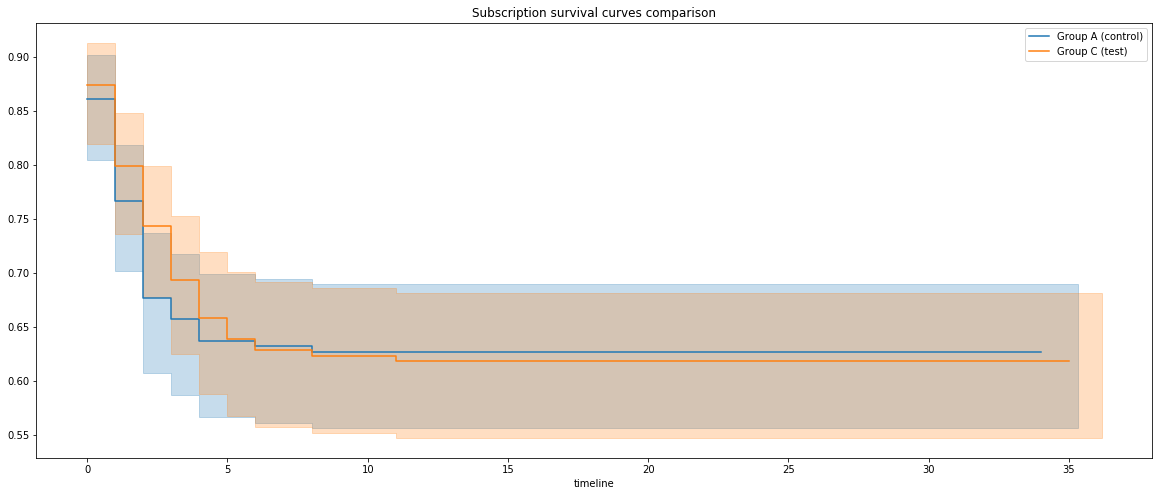

In [21]:
%matplotlib inline

groups = start_end.index.get_level_values(0)
ix_a = (groups == u'a')
ix_c = (groups == u'c')

kmf.fit(T[ix_a], E[ix_a], label='Group A (control)')
ax = kmf.plot()

kmf.fit(T[ix_c], E[ix_c], label='Group C (test)')
kmf.plot(ax=ax, figsize=(20,8), title='Subscription survival curves comparison')

Survival curves show the proportion of subsribed users that remains subsribed with each day after subscription (see the timeline).

The confidence intervals for the survival curves on the graph intersect, so we can say that there is no statistically significant difference in subscription survival between the groups A and C.

There is no statistical difference in subscription survival time between the groups A and C, so we can just compare the actual amount of money that we recieved from the groups A and C during the experiment to choose the best option.

In [22]:
def diff_weeks(start, end):
    x = end - start
    return int(x / np.timedelta64(1, 'W'))

def diff_days(start, end):
    x = end - start
    return int(x / np.timedelta64(1, 'D'))

We apply the first payment scheme (5 units per week even if it's incomplete) to the group A (control) and the second payment scheme (0.8 units per day even if it's incomplete) to the group C (test). I assume that all the payments are made in advance (at the beginning of a payment period).

We use either the last date in the data or the unsubscription date as an end date for every subscribed user.

In [23]:
start_end = start_end.fillna(df.date.max())

start_end['weeks_paid'] = start_end.apply(lambda row: diff_weeks(row.start, row.end) + 1, axis=1)
start_end['days_paid'] = start_end.apply(lambda row: diff_days(row.start, row.end) + 1, axis=1)

start_end['weeks_paid_amount'] = start_end['weeks_paid'] * 5.
start_end['days_paid_amount'] = start_end['days_paid'] * 0.8

print 'The total amount of money received from the group A: %.1f\nThe total amount of money received from the group received from the group C: %.1f' % (
    start_end[ix_a].weeks_paid_amount.sum(),
    start_end[ix_c].days_paid_amount.sum()
)

print 'The average amount of money received from a subscribed user in the group A: %.1f\nThe average amount of money received from a subscribed user in the group C: %.1f' % (
    start_end[ix_a].weeks_paid_amount.mean(),
    start_end[ix_c].days_paid_amount.mean()
)

The total amount of money received from the group A: 2975.0
The total amount of money received from the group received from the group C: 2768.8
The average amount of money received from a subscribed user in the group A: 14.8
The average amount of money received from a subscribed user in the group C: 13.9


We can see that both the average amount of money received (per a subscribed user) and the total amount of money received is higher for the control group A.

We can perform a statistical test to compare the average amount of money received from a subscribed user between the groups.

In [24]:
test = stats.ttest_ind(start_end[ix_a].weeks_paid_amount, start_end[ix_c].days_paid_amount)
print '{0:0.3f}'.format(test.pvalue)

0.321


The test says that there is no statistically significant difference in the average amount of money received from a subscribed user between the groups A and C.

We used a t-test for independent samples to compare the means. The test gives us a p-value that equals 0.321 that is higher than 0.05 or even 0.10, so we can't reject the null hypothesis that the means are equal among the groups.

Thus there is no statistically significant difference in subscription rates, subscription to unsubscription conversion rates, subscription survival and the average amount of money received from a subscribed user between the test (C) and the control (A) groups, and the control group has even brought us more money in total, so I see no reason why the company should switch to the payment scheme used in the group C.

## Short summary

1. The average number of minigame plays before a user subscribes is 2.13 and the average number of song plays before a user subscribes is 2.20.
2. There is no statistically significant difference in the conversion rate from account creation to the first song played between the group B and the control group.
3. According to my calculations, the experiment of the group C does not bring more money to the company.